#  Прогнозирование заказов такси

## Загрузка библиотек. Знакомство с данными

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GroupShuffleSplit
import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# считываем датафрейм
try:
    df=pd.read_csv('C:\\Python\\ЯП\\проект_9\\taxi.csv', sep=',', parse_dates=[0], index_col=[0])

except:
    df=pd.read_csv('/datasets/taxi.csv', sep=',', parse_dates=[0], index_col=[0])

In [4]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
df.isnull().sum()

num_orders    0
dtype: int64

Посмотрим на сезонность

In [6]:
df.sort_index(inplace=True)
df_M = df.resample('1D').sum()
df_M

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


In [7]:
decomposed = seasonal_decompose(df_M) 

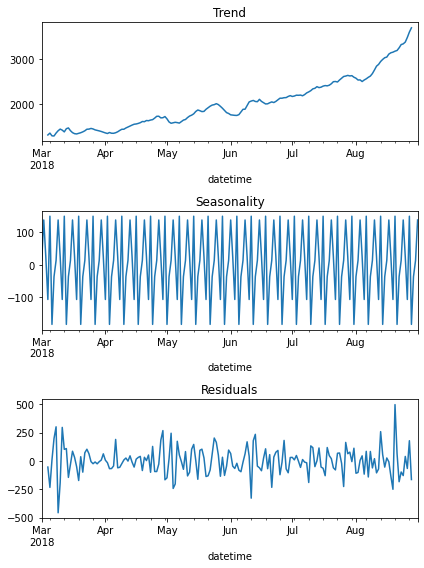

In [8]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

к концу года идет тренд на увеличение кол-ва заказов 

In [9]:
print(df.index.is_monotonic)

True


Все ок!даты и время расположены в хронологическом порядке 

#### Выполним ресемплирование по одному часу

In [10]:
df = df.resample('1H').sum()

df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


колличество данных ожидаемо уменьшилось в 6 раз из-за укрупнения "окна" наблюдения

Посмотрим на график

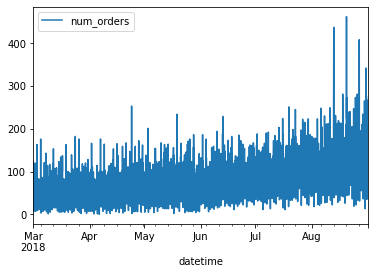

In [11]:
df.resample('1H').sum().plot();

Чтобы во временном ряду снизить колебания, применим скользящее среднее. Так же прогнозировать данные помогают стационарные ряды

#### Создадим признаки

Создадим несколько дополнительных фичей. 

Скользящее среднее как признак задаёт общий тренд временного ряда

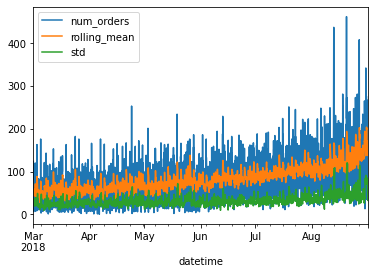

In [12]:
df['rolling_mean'] = df['num_orders'].rolling(12).mean()
df['std'] = df['num_orders'].rolling(12).std()
df.plot();

Ряды с трендами не стационарны. Ряды с сезонностью не стационарны.

Временной ряд НЕ cтационарный.

Посмотрим скролько у нас пропусков 

In [13]:
df.isnull().sum()

num_orders       0
rolling_mean    11
std             11
dtype: int64

уберем пропуски, т.к. считаем что если не было заказов, то должно быть число 0, и их всего 11...

In [14]:
df.shape

(4416, 3)

In [15]:
df = df.loc[df['rolling_mean'].isnull()==False]
df

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 11:00:00,96,57.083333,36.154865
2018-03-01 12:00:00,30,49.250000,29.997348
2018-03-01 13:00:00,32,44.833333,28.096695
2018-03-01 14:00:00,48,42.916667,26.908797
2018-03-01 15:00:00,66,42.916667,26.908797
...,...,...,...
2018-08-31 19:00:00,136,170.916667,33.835050
2018-08-31 20:00:00,154,168.583333,33.966450
2018-08-31 21:00:00,159,164.916667,32.244685


Календарные признаки + «Отстающие значения» 

In [16]:
def make_features(df, max_lag):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [17]:
df

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 11:00:00,96,57.083333,36.154865
2018-03-01 12:00:00,30,49.250000,29.997348
2018-03-01 13:00:00,32,44.833333,28.096695
2018-03-01 14:00:00,48,42.916667,26.908797
2018-03-01 15:00:00,66,42.916667,26.908797
...,...,...,...
2018-08-31 19:00:00,136,170.916667,33.835050
2018-08-31 20:00:00,154,168.583333,33.966450
2018-08-31 21:00:00,159,164.916667,32.244685


У нас будет несколько моделей машинного обучения. Для упрощения процесса(чтобы не путаться), для каждой из них создадим свою копию

In [18]:
df_copy = df.copy()
df_copy_1 = df.copy()
df_copy_2 = df.copy()
df_copy_3 = df.copy()


### Обучение моделей

#### Для начала рассмотрим модель линейной регрессии

т.к. эта модель достаточно быстро считает то мы циклом пробежимся по всем параметрам и посмотрим какое кол-во дополнительных параметров лучше всего применить

In [19]:
for i in range(1,30):
    make_features(df_copy, i)
    train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
    features_test = test.drop(['num_orders'], axis=1)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions_train = model.predict(features_train)
    predictions_train.shape
    
    
    
    print('для i =',i)
    print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
    print(' ')

для i = 1
RMSE обучающей выборки: 30.37477112521214
 
для i = 2
RMSE обучающей выборки: 30.364431348307527
 
для i = 3
RMSE обучающей выборки: 29.9460369645648
 
для i = 4
RMSE обучающей выборки: 29.55626568289355
 
для i = 5
RMSE обучающей выборки: 29.290639700264112
 
для i = 6
RMSE обучающей выборки: 28.87755722647001
 
для i = 7
RMSE обучающей выборки: 28.728861705903594
 
для i = 8
RMSE обучающей выборки: 28.12875709899552
 
для i = 9
RMSE обучающей выборки: 25.144784367000504
 
для i = 10
RMSE обучающей выборки: 20.01121315289384
 
для i = 11
RMSE обучающей выборки: 2.0524703591510656e-13
 
для i = 12
RMSE обучающей выборки: 2.850527830737518e-13
 
для i = 13
RMSE обучающей выборки: 1.909803091839825e-13
 
для i = 14
RMSE обучающей выборки: 3.8413045705809125e-13
 
для i = 15
RMSE обучающей выборки: 1.8294799682386563e-13
 
для i = 16
RMSE обучающей выборки: 1.686337423699066e-13
 
для i = 17
RMSE обучающей выборки: 1.7722152135935128e-13
 
для i = 18
RMSE обучающей выборки: 3.87

Для дальнейших исследований выбрал i=10

In [20]:
df.head()

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 11:00:00,96,57.083333,36.154865
2018-03-01 12:00:00,30,49.250000,29.997348
2018-03-01 13:00:00,32,44.833333,28.096695
2018-03-01 14:00:00,48,42.916667,26.908797
2018-03-01 15:00:00,66,42.916667,26.908797


In [21]:
make_features(df, 10)

In [22]:
df.head()

,num_orders,rolling_mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,,,,
2018-03-01 11:00:00,96,57.083333,36.154865,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 12:00:00,30,49.250000,29.997348,2018,3,1,3,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 13:00:00,32,44.833333,28.096695,2018,3,1,3,30.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 14:00:00,48,42.916667,26.908797,2018,3,1,3,32.0,30.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 15:00:00,66,42.916667,26.908797,2018,3,1,3,48.0,32.0,30.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN


разобьем наши данные на тренировочную и тестовую выборки

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

В качестве параметра кросс валидации используем TimeSeriesSplit. Этот парметр используется в задачах с числовыми рядами

In [24]:
tscv = TimeSeriesSplit(n_splits = 5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [25]:
model_L = GridSearchCV(LinearRegression(),param_grid={},cv=tscv,n_jobs=-1)
model_L.fit(features_train, target_train)

predictions_train = model_L.predict(features_train)
predictions = model_L.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions)**0.5)

RMSE обучающей выборки: 20.01121315289384
RMSE тестовой выборки:  32.92118524611929


RMSE тестовой выборки получили равно 33. Неплохой результат.

Обучим модель CatBoostRegressor.

Т.к. обучкение занимает очень много времени заккоментируем код и приведем ниже код уже с наилучшими параметрами. Тенденция следующая: чем больше число i(кол-во фичей) тем лучше получаем RMSE. В этом случае подозрительно маленьких значений не возникает. И указываем значение i побольше. (например 200)

In [26]:
#i_value = []
#RMSE_train_value = []
#RMSE_test_value = []

In [27]:
#for i in range(1,106,5):
#    make_features(df_copy_1, i)
#    train, test = train_test_split(df_copy_1, shuffle=False, test_size=0.1)
#    train = train.dropna()
#    
#    target_train = train['num_orders']
#    features_train = train.drop(['num_orders'], axis=1)
#    target_test = test['num_orders']
#    features_test = test.drop(['num_orders'], axis=1)


#    cat = GridSearchCV(
#                estimator=CatBoostRegressor(loss_function='RMSE', random_state=12345),
#                param_grid={"learning_rate": (0.001, 0.01),
#                            "iterations":[3000]},
#                cv=tscv, verbose=100, n_jobs=-1)
#
#    grid_result = cat.fit(features_train, target_train)
#
#    print(f'Лучшие параметры модели {grid_result.best_params_}')
#
#    predictions_train = grid_result.predict(features_train)
#    predictions_test = grid_result.predict(features_test)
#
#    print('i = ', i)
#    print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
#    print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)
    
#    i_value.append(i)
#    RMSE_train_value.append(mean_squared_error(target_train, predictions_train)**0.5)
#    RMSE_test_value.append(mean_squared_error(target_test, predictions_test)**0.5)

In [28]:
#i_value = pd.Series(i_value)
#RMSE_train_value = pd.Series(RMSE_train_value)
#RMSE_test_value = pd.Series(RMSE_test_value)

#res = pd.DataFrame({'i_value':i_value,'RMSE_train_value':RMSE_train_value,'RMSE_test_value':RMSE_test_value})
#res

In [29]:
make_features(df_copy_1, 200)
train, test = train_test_split(df_copy_1, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)


cat = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE',
                                               learning_rate = 0.01,
                                               iterations  = 2000,
                                               random_state=12345),
                   param_grid={},cv=tscv, verbose=100, n_jobs=-1)


grid_result = cat.fit(features_train, target_train)

predictions_train = grid_result.predict(features_train)
predictions = grid_result.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions)**0.5)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 38.4711626	total: 192ms	remaining: 6m 24s
1:	learn: 38.2756771	total: 212ms	remaining: 3m 31s
2:	learn: 38.0667353	total: 226ms	remaining: 2m 30s
3:	learn: 37.8541710	total: 238ms	remaining: 1m 58s
4:	learn: 37.6422367	total: 249ms	remaining: 1m 39s
5:	learn: 37.4561286	total: 267ms	remaining: 1m 28s
6:	learn: 37.2346816	total: 278ms	remaining: 1m 19s
7:	learn: 37.0305095	total: 289ms	remaining: 1m 12s
8:	learn: 36.8344401	total: 300ms	remaining: 1m 6s
9:	learn: 36.6377398	total: 311ms	remaining: 1m 1s
10:	learn: 36.4444446	total: 322ms	remaining: 58.3s
11:	learn: 36.2552309	total: 333ms	remaining: 55.2s
12:	learn: 36.0730429	total: 345ms	remaining: 52.7s
13:	learn: 35.8775689	total: 356ms	remaining: 50.5s
14:	learn: 35.6954151	total: 367ms	remaining: 48.5s
15:	learn: 35.5251621	total: 378ms	remaining: 46.9s
16:	learn: 35.3450931	total: 389ms	remaining: 45.4s
17:	learn: 35.1520393	total: 400ms	remaining: 44s
18:	learn

172:	learn: 22.1859809	total: 2.21s	remaining: 23.4s
173:	learn: 22.1542309	total: 2.22s	remaining: 23.3s
174:	learn: 22.1232823	total: 2.23s	remaining: 23.3s
175:	learn: 22.0891157	total: 2.25s	remaining: 23.3s
176:	learn: 22.0633081	total: 2.26s	remaining: 23.2s
177:	learn: 22.0316163	total: 2.27s	remaining: 23.2s
178:	learn: 21.9999778	total: 2.28s	remaining: 23.2s
179:	learn: 21.9693358	total: 2.32s	remaining: 23.5s
180:	learn: 21.9381819	total: 2.34s	remaining: 23.5s
181:	learn: 21.9058079	total: 2.35s	remaining: 23.5s
182:	learn: 21.8767754	total: 2.36s	remaining: 23.4s
183:	learn: 21.8464322	total: 2.37s	remaining: 23.4s
184:	learn: 21.8174791	total: 2.38s	remaining: 23.4s
185:	learn: 21.7918622	total: 2.39s	remaining: 23.3s
186:	learn: 21.7639741	total: 2.4s	remaining: 23.3s
187:	learn: 21.7343075	total: 2.42s	remaining: 23.3s
188:	learn: 21.7066132	total: 2.43s	remaining: 23.3s
189:	learn: 21.6802515	total: 2.44s	remaining: 23.2s
190:	learn: 21.6543941	total: 2.45s	remaining: 

332:	learn: 19.4830430	total: 4.04s	remaining: 20.2s
333:	learn: 19.4737746	total: 4.05s	remaining: 20.2s
334:	learn: 19.4720149	total: 4.06s	remaining: 20.2s
335:	learn: 19.4604877	total: 4.07s	remaining: 20.2s
336:	learn: 19.4582155	total: 4.08s	remaining: 20.2s
337:	learn: 19.4555875	total: 4.09s	remaining: 20.1s
338:	learn: 19.4454811	total: 4.11s	remaining: 20.1s
339:	learn: 19.4421265	total: 4.12s	remaining: 20.1s
340:	learn: 19.4399317	total: 4.13s	remaining: 20.1s
341:	learn: 19.4343041	total: 4.14s	remaining: 20.1s
342:	learn: 19.4293276	total: 4.15s	remaining: 20s
343:	learn: 19.4219330	total: 4.16s	remaining: 20s
344:	learn: 19.4119772	total: 4.17s	remaining: 20s
345:	learn: 19.4026123	total: 4.18s	remaining: 20s
346:	learn: 19.3952474	total: 4.19s	remaining: 20s
347:	learn: 19.3861110	total: 4.21s	remaining: 20s
348:	learn: 19.3844476	total: 4.22s	remaining: 19.9s
349:	learn: 19.3774568	total: 4.23s	remaining: 19.9s
350:	learn: 19.3662855	total: 4.24s	remaining: 19.9s
351:	

494:	learn: 18.5383593	total: 5.87s	remaining: 17.8s
495:	learn: 18.5321396	total: 5.88s	remaining: 17.8s
496:	learn: 18.5298714	total: 5.89s	remaining: 17.8s
497:	learn: 18.5282228	total: 5.9s	remaining: 17.8s
498:	learn: 18.5271287	total: 5.91s	remaining: 17.8s
499:	learn: 18.5193364	total: 5.92s	remaining: 17.8s
500:	learn: 18.5125605	total: 5.93s	remaining: 17.8s
501:	learn: 18.5058866	total: 5.96s	remaining: 17.8s
502:	learn: 18.4995708	total: 5.97s	remaining: 17.8s
503:	learn: 18.4986593	total: 5.98s	remaining: 17.7s
504:	learn: 18.4938538	total: 5.99s	remaining: 17.7s
505:	learn: 18.4912931	total: 6s	remaining: 17.7s
506:	learn: 18.4860573	total: 6.01s	remaining: 17.7s
507:	learn: 18.4800723	total: 6.03s	remaining: 17.7s
508:	learn: 18.4764835	total: 6.04s	remaining: 17.7s
509:	learn: 18.4746006	total: 6.05s	remaining: 17.7s
510:	learn: 18.4688715	total: 6.06s	remaining: 17.7s
511:	learn: 18.4679091	total: 6.07s	remaining: 17.6s
512:	learn: 18.4667947	total: 6.08s	remaining: 17.

658:	learn: 17.8166853	total: 7.69s	remaining: 15.7s
659:	learn: 17.8122028	total: 7.7s	remaining: 15.6s
660:	learn: 17.8075798	total: 7.71s	remaining: 15.6s
661:	learn: 17.8030565	total: 7.73s	remaining: 15.6s
662:	learn: 17.8008848	total: 7.74s	remaining: 15.6s
663:	learn: 17.7954844	total: 7.75s	remaining: 15.6s
664:	learn: 17.7908630	total: 7.76s	remaining: 15.6s
665:	learn: 17.7898854	total: 7.77s	remaining: 15.6s
666:	learn: 17.7853167	total: 7.78s	remaining: 15.6s
667:	learn: 17.7824276	total: 7.79s	remaining: 15.5s
668:	learn: 17.7798486	total: 7.8s	remaining: 15.5s
669:	learn: 17.7740510	total: 7.81s	remaining: 15.5s
670:	learn: 17.7724875	total: 7.82s	remaining: 15.5s
671:	learn: 17.7672577	total: 7.83s	remaining: 15.5s
672:	learn: 17.7638958	total: 7.85s	remaining: 15.5s
673:	learn: 17.7578289	total: 7.86s	remaining: 15.5s
674:	learn: 17.7553356	total: 7.87s	remaining: 15.4s
675:	learn: 17.7516162	total: 7.88s	remaining: 15.4s
676:	learn: 17.7477574	total: 7.89s	remaining: 1

820:	learn: 17.2139079	total: 9.54s	remaining: 13.7s
821:	learn: 17.2107592	total: 9.55s	remaining: 13.7s
822:	learn: 17.2074833	total: 9.56s	remaining: 13.7s
823:	learn: 17.2028635	total: 9.57s	remaining: 13.7s
824:	learn: 17.1992459	total: 9.58s	remaining: 13.6s
825:	learn: 17.1963561	total: 9.59s	remaining: 13.6s
826:	learn: 17.1940814	total: 9.62s	remaining: 13.6s
827:	learn: 17.1898999	total: 9.63s	remaining: 13.6s
828:	learn: 17.1875980	total: 9.65s	remaining: 13.6s
829:	learn: 17.1837549	total: 9.66s	remaining: 13.6s
830:	learn: 17.1784712	total: 9.67s	remaining: 13.6s
831:	learn: 17.1717760	total: 9.68s	remaining: 13.6s
832:	learn: 17.1682124	total: 9.69s	remaining: 13.6s
833:	learn: 17.1674759	total: 9.7s	remaining: 13.6s
834:	learn: 17.1634933	total: 9.71s	remaining: 13.6s
835:	learn: 17.1577889	total: 9.72s	remaining: 13.5s
836:	learn: 17.1567449	total: 9.73s	remaining: 13.5s
837:	learn: 17.1515637	total: 9.75s	remaining: 13.5s
838:	learn: 17.1473797	total: 9.76s	remaining: 

983:	learn: 16.5924027	total: 11.4s	remaining: 11.7s
984:	learn: 16.5867456	total: 11.4s	remaining: 11.7s
985:	learn: 16.5823243	total: 11.4s	remaining: 11.7s
986:	learn: 16.5761208	total: 11.4s	remaining: 11.7s
987:	learn: 16.5755387	total: 11.4s	remaining: 11.7s
988:	learn: 16.5745752	total: 11.4s	remaining: 11.7s
989:	learn: 16.5738558	total: 11.4s	remaining: 11.7s
990:	learn: 16.5701976	total: 11.4s	remaining: 11.6s
991:	learn: 16.5676897	total: 11.4s	remaining: 11.6s
992:	learn: 16.5669016	total: 11.5s	remaining: 11.6s
993:	learn: 16.5627877	total: 11.5s	remaining: 11.6s
994:	learn: 16.5620522	total: 11.5s	remaining: 11.6s
995:	learn: 16.5559696	total: 11.5s	remaining: 11.6s
996:	learn: 16.5508947	total: 11.5s	remaining: 11.6s
997:	learn: 16.5480330	total: 11.5s	remaining: 11.6s
998:	learn: 16.5475396	total: 11.5s	remaining: 11.5s
999:	learn: 16.5470254	total: 11.5s	remaining: 11.5s
1000:	learn: 16.5462911	total: 11.5s	remaining: 11.5s
1001:	learn: 16.5456533	total: 11.6s	remainin

1143:	learn: 16.1690723	total: 13.2s	remaining: 9.87s
1144:	learn: 16.1642759	total: 13.2s	remaining: 9.86s
1145:	learn: 16.1592913	total: 13.2s	remaining: 9.85s
1146:	learn: 16.1533656	total: 13.2s	remaining: 9.84s
1147:	learn: 16.1494324	total: 13.2s	remaining: 9.83s
1148:	learn: 16.1468089	total: 13.3s	remaining: 9.81s
1149:	learn: 16.1427793	total: 13.3s	remaining: 9.8s
1150:	learn: 16.1371535	total: 13.3s	remaining: 9.79s
1151:	learn: 16.1321359	total: 13.3s	remaining: 9.78s
1152:	learn: 16.1278376	total: 13.3s	remaining: 9.77s
1153:	learn: 16.1236850	total: 13.3s	remaining: 9.76s
1154:	learn: 16.1204128	total: 13.3s	remaining: 9.74s
1155:	learn: 16.1141441	total: 13.3s	remaining: 9.73s
1156:	learn: 16.1097062	total: 13.3s	remaining: 9.72s
1157:	learn: 16.1045929	total: 13.3s	remaining: 9.71s
1158:	learn: 16.1005139	total: 13.4s	remaining: 9.7s
1159:	learn: 16.0940133	total: 13.4s	remaining: 9.68s
1160:	learn: 16.0893848	total: 13.4s	remaining: 9.67s
1161:	learn: 16.0853194	total:

1299:	learn: 15.5527056	total: 15s	remaining: 8.09s
1300:	learn: 15.5483219	total: 15s	remaining: 8.08s
1301:	learn: 15.5453682	total: 15s	remaining: 8.06s
1302:	learn: 15.5407584	total: 15.1s	remaining: 8.05s
1303:	learn: 15.5368754	total: 15.1s	remaining: 8.04s
1304:	learn: 15.5329746	total: 15.1s	remaining: 8.03s
1305:	learn: 15.5300793	total: 15.1s	remaining: 8.02s
1306:	learn: 15.5257885	total: 15.1s	remaining: 8.01s
1307:	learn: 15.5207771	total: 15.1s	remaining: 8s
1308:	learn: 15.5180241	total: 15.1s	remaining: 7.98s
1309:	learn: 15.5158462	total: 15.1s	remaining: 7.97s
1310:	learn: 15.5127318	total: 15.1s	remaining: 7.96s
1311:	learn: 15.5096404	total: 15.2s	remaining: 7.95s
1312:	learn: 15.5072096	total: 15.2s	remaining: 7.94s
1313:	learn: 15.5013944	total: 15.2s	remaining: 7.92s
1314:	learn: 15.4979021	total: 15.2s	remaining: 7.91s
1315:	learn: 15.4960796	total: 15.2s	remaining: 7.9s
1316:	learn: 15.4903595	total: 15.2s	remaining: 7.89s
1317:	learn: 15.4879021	total: 15.2s	r

1464:	learn: 14.9944707	total: 16.8s	remaining: 6.15s
1465:	learn: 14.9912929	total: 16.9s	remaining: 6.14s
1466:	learn: 14.9872928	total: 16.9s	remaining: 6.13s
1467:	learn: 14.9849540	total: 16.9s	remaining: 6.12s
1468:	learn: 14.9817186	total: 16.9s	remaining: 6.11s
1469:	learn: 14.9782448	total: 16.9s	remaining: 6.09s
1470:	learn: 14.9756132	total: 16.9s	remaining: 6.08s
1471:	learn: 14.9706872	total: 16.9s	remaining: 6.07s
1472:	learn: 14.9661708	total: 16.9s	remaining: 6.06s
1473:	learn: 14.9624459	total: 16.9s	remaining: 6.05s
1474:	learn: 14.9585388	total: 17s	remaining: 6.04s
1475:	learn: 14.9544080	total: 17s	remaining: 6.03s
1476:	learn: 14.9505132	total: 17s	remaining: 6.01s
1477:	learn: 14.9470777	total: 17s	remaining: 6s
1478:	learn: 14.9433507	total: 17s	remaining: 5.99s
1479:	learn: 14.9382273	total: 17s	remaining: 5.98s
1480:	learn: 14.9342633	total: 17s	remaining: 5.97s
1481:	learn: 14.9309669	total: 17s	remaining: 5.96s
1482:	learn: 14.9275141	total: 17.1s	remaining:

1622:	learn: 14.4801474	total: 18.7s	remaining: 4.34s
1623:	learn: 14.4763613	total: 18.7s	remaining: 4.33s
1624:	learn: 14.4745800	total: 18.7s	remaining: 4.31s
1625:	learn: 14.4717600	total: 18.7s	remaining: 4.3s
1626:	learn: 14.4696878	total: 18.7s	remaining: 4.29s
1627:	learn: 14.4682795	total: 18.7s	remaining: 4.28s
1628:	learn: 14.4646051	total: 18.7s	remaining: 4.27s
1629:	learn: 14.4601261	total: 18.7s	remaining: 4.26s
1630:	learn: 14.4559642	total: 18.8s	remaining: 4.24s
1631:	learn: 14.4524168	total: 18.8s	remaining: 4.23s
1632:	learn: 14.4485988	total: 18.8s	remaining: 4.22s
1633:	learn: 14.4458651	total: 18.8s	remaining: 4.21s
1634:	learn: 14.4427237	total: 18.8s	remaining: 4.2s
1635:	learn: 14.4391374	total: 18.8s	remaining: 4.19s
1636:	learn: 14.4360189	total: 18.8s	remaining: 4.17s
1637:	learn: 14.4324933	total: 18.8s	remaining: 4.16s
1638:	learn: 14.4303579	total: 18.8s	remaining: 4.15s
1639:	learn: 14.4280441	total: 18.9s	remaining: 4.14s
1640:	learn: 14.4245864	total:

1787:	learn: 13.9751112	total: 20.5s	remaining: 2.43s
1788:	learn: 13.9726635	total: 20.5s	remaining: 2.42s
1789:	learn: 13.9694583	total: 20.5s	remaining: 2.41s
1790:	learn: 13.9675066	total: 20.5s	remaining: 2.4s
1791:	learn: 13.9655237	total: 20.5s	remaining: 2.38s
1792:	learn: 13.9623268	total: 20.6s	remaining: 2.37s
1793:	learn: 13.9601275	total: 20.6s	remaining: 2.36s
1794:	learn: 13.9579259	total: 20.6s	remaining: 2.35s
1795:	learn: 13.9546192	total: 20.6s	remaining: 2.34s
1796:	learn: 13.9521554	total: 20.6s	remaining: 2.33s
1797:	learn: 13.9497097	total: 20.6s	remaining: 2.31s
1798:	learn: 13.9480032	total: 20.6s	remaining: 2.3s
1799:	learn: 13.9464012	total: 20.6s	remaining: 2.29s
1800:	learn: 13.9441353	total: 20.6s	remaining: 2.28s
1801:	learn: 13.9400753	total: 20.7s	remaining: 2.27s
1802:	learn: 13.9370306	total: 20.7s	remaining: 2.26s
1803:	learn: 13.9333487	total: 20.7s	remaining: 2.25s
1804:	learn: 13.9317011	total: 20.7s	remaining: 2.23s
1805:	learn: 13.9280406	total:

1952:	learn: 13.5394981	total: 22.3s	remaining: 537ms
1953:	learn: 13.5374344	total: 22.3s	remaining: 526ms
1954:	learn: 13.5327116	total: 22.4s	remaining: 514ms
1955:	learn: 13.5290773	total: 22.4s	remaining: 503ms
1956:	learn: 13.5251657	total: 22.4s	remaining: 492ms
1957:	learn: 13.5218405	total: 22.4s	remaining: 480ms
1958:	learn: 13.5187583	total: 22.4s	remaining: 469ms
1959:	learn: 13.5140181	total: 22.4s	remaining: 457ms
1960:	learn: 13.5116536	total: 22.4s	remaining: 446ms
1961:	learn: 13.5088633	total: 22.4s	remaining: 434ms
1962:	learn: 13.5070337	total: 22.4s	remaining: 423ms
1963:	learn: 13.5057628	total: 22.5s	remaining: 412ms
1964:	learn: 13.5017175	total: 22.5s	remaining: 400ms
1965:	learn: 13.5007832	total: 22.5s	remaining: 389ms
1966:	learn: 13.4983727	total: 22.5s	remaining: 378ms
1967:	learn: 13.4951864	total: 22.5s	remaining: 367ms
1968:	learn: 13.4925631	total: 22.6s	remaining: 355ms
1969:	learn: 13.4897521	total: 22.6s	remaining: 344ms
1970:	learn: 13.4866989	tota

значение RMSE тестовой выборки: 35.7. Так же неплохой результат

Обучим модель LGBMModel.

Т.к. обучкение занимает очень много времени заккоментируем код и приведем ниже код уже с наилучшими параметрами.

In [30]:
#i_value = []
#RMSE_train_value = []
#RMSE_test_value = []

In [31]:
#for i in range(1,156,5):
#    make_features(df_copy_2, i)
#    train, test = train_test_split(df_copy_2, shuffle=False, test_size=0.1)
#    train = train.dropna()
#    
#    target_train = train['num_orders']
#    features_train = train.drop(['num_orders'], axis=1)
#    target_test = test['num_orders']
#    features_test = test.drop(['num_orders'], axis=1)
#
#    model_lgb = GridSearchCV(
#                estimator=lgb.LGBMModel(objective="regression"),
#                param_grid={"learning_rate": (0.05, 0.01),
#                            "max_depth": [5, 7],
#                            "n_estimators": [500],
#                            "iterations":[300]
#                           },
#                cv=tscv,scoring='neg_mean_squared_error', verbose=100, n_jobs=-1)
#
#    grid_result = model_lgb.fit(features_train, target_train)
#
#    print(f'Лучшие параметры модели {grid_result.best_params_}')
#
#    predictions_train = grid_result.predict(features_train)
#    predictions_test = grid_result.predict(features_test)
#
#    print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
#    print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions)**0.5)
#    
#    i_value.append(i)
#    RMSE_train_value.append(mean_squared_error(target_train, predictions_train)**0.5)
#    RMSE_test_value.append(mean_squared_error(target_test, predictions_test)**0.5)

In [32]:
#i_value = pd.Series(i_value)
#RMSE_train_value = pd.Series(RMSE_train_value)
#RMSE_test_value = pd.Series(RMSE_test_value)

#res = pd.DataFrame({'i_value':i_value,'RMSE_train_value':RMSE_train_value,'RMSE_test_value':RMSE_test_value})
#res

In [33]:
make_features(df_copy_3, 1000)
train, test = train_test_split(df_copy_3, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

model_lgb = GridSearchCV(estimator=lgb.LGBMModel(objective="regression",
                                                 learning_rate=0.05,
                                                 max_depth = 5,
                                                 n_estimators = 500),
                         param_grid={}, cv=tscv,scoring='neg_mean_squared_error', verbose=100, n_jobs=-1)

grid_result = model_lgb.fit(features_train, target_train)

predictions_train = grid_result.predict(features_train)
predictions = grid_result.predict(features_test)

print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train)**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions)**0.5)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
RMSE обучающей выборки: 5.620215363791204
RMSE тестовой выборки:  33.84502730854645


RMSE тестовой выборки:  33.8. Хороший результат.

Посмотрим на наши пердсказания.

                     Ответы  Предсказания
datetime                                 
2018-08-13 15:00:00     175    136.920329
2018-08-13 16:00:00     144    151.625014
2018-08-13 17:00:00     152    152.280005
2018-08-13 18:00:00     104     75.655857
2018-08-13 19:00:00      91    102.778783
...                     ...           ...
2018-08-31 19:00:00     136    129.419585
2018-08-31 20:00:00     154    142.404037
2018-08-31 21:00:00     159    173.687115
2018-08-31 22:00:00     223    174.893921
2018-08-31 23:00:00     205    196.527439

[441 rows x 2 columns]


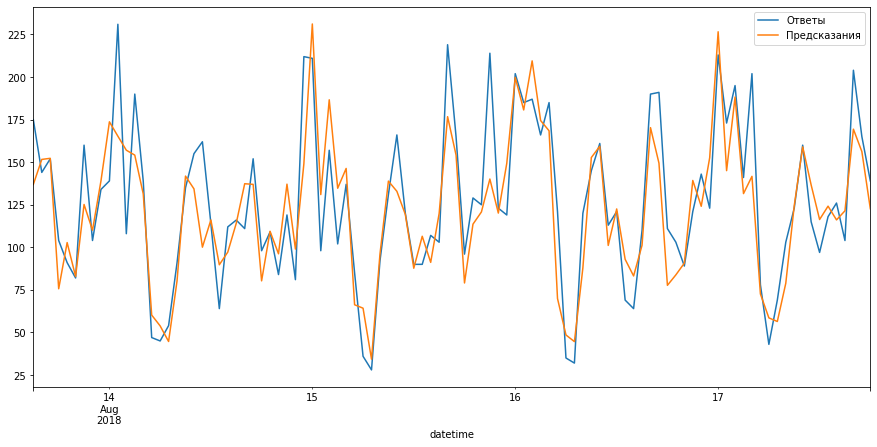

In [34]:
gr = pd.DataFrame({'Ответы':target_test, 'Предсказания':predictions});
print(gr)
gr.head(100).plot(figsize=(15, 7));

Как видно из графика, наша модель предсказывает достаточно точно.

Посмотрим какие фичи оказались наиболее и наименее ценными

In [35]:
model_lgb = lgb.LGBMModel(objective="regression", n_estimators = 500, learning_rate = 0.05, max_depth = 5)
model_lgb.fit(features_train, target_train)
predictions_test = model_lgb.predict(features_test)

<AxesSubplot:xlabel='feature'>

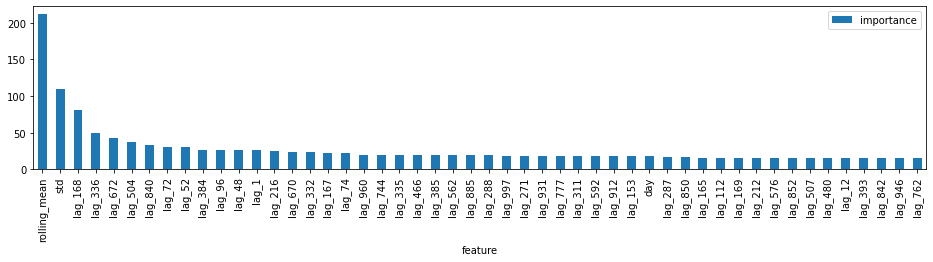

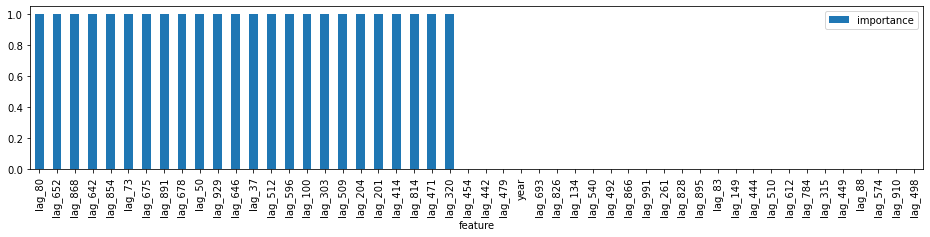

In [36]:
importances = pd.DataFrame({'feature':features_test.columns,'importance':np.round(model_lgb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(50).plot.bar(figsize=(16, 3))
importances.tail(50).plot.bar(figsize=(16, 3))

roling_mean и std оказались наиболее ценными фичами с точки зрения предсказания

фича year оказалась не очень полезной

## Выводы:

Все рассмотренные модели показали неплохие результаты. Наиболее точной и быстрой оказалась модель линейной регрессии LinearRegression. Полученные ошибки на всех моделях RMSE<48.